In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

## PyMC3 primer

In [3]:
np.random.seed(123)
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

In [4]:
with pm.Model() as our_first_model:
    # a priori
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3339.13draws/s]


### Summarizing the posterior

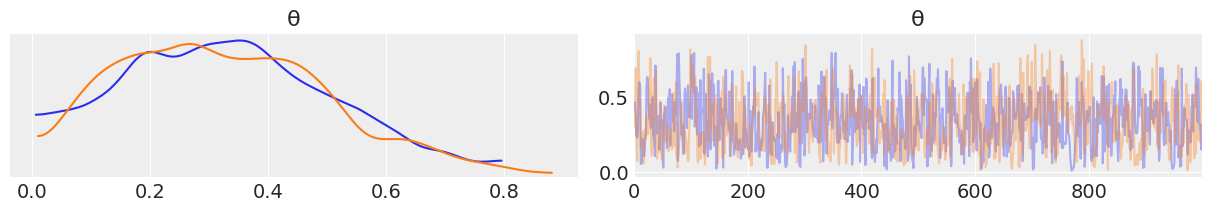

In [5]:
az.plot_trace(trace)
plt.savefig('B11197_02_01.png')

In [6]:
az.summary(trace)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
θ,0.33,0.18,0.0,0.02,0.64,847.0,1.0


#### Posterior-based decisions

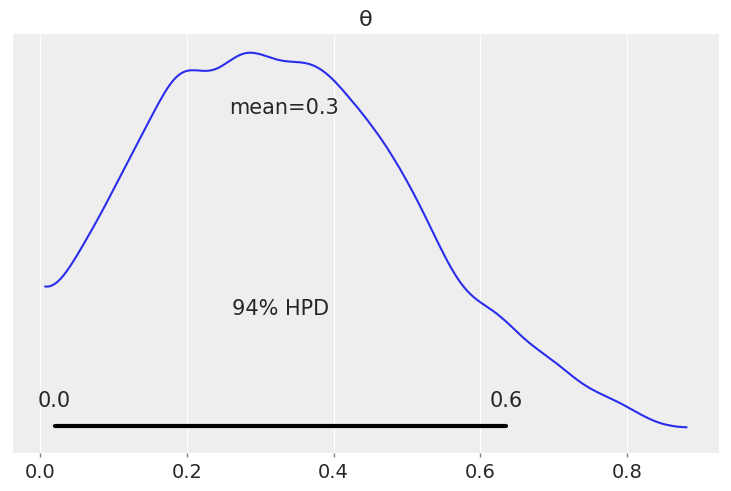

In [7]:
az.plot_posterior(trace)
plt.savefig('B11197_02_02.png', dpi=300)

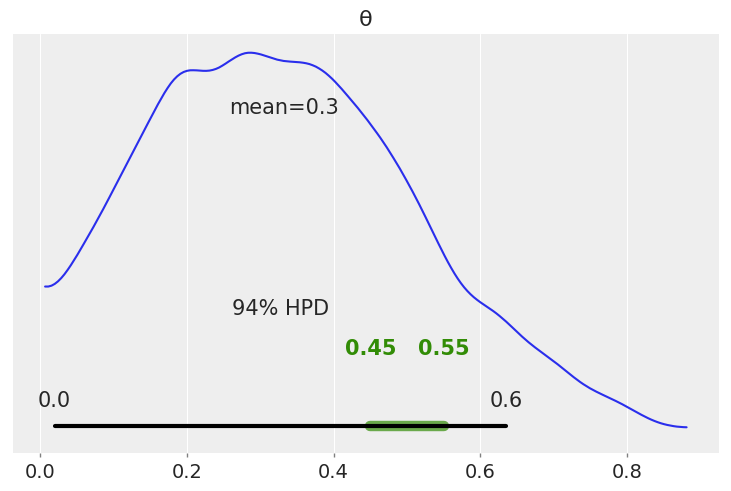

In [8]:
az.plot_posterior(trace, rope=[0.45, .55])
plt.savefig('B11197_02_03.png', dpi=300)

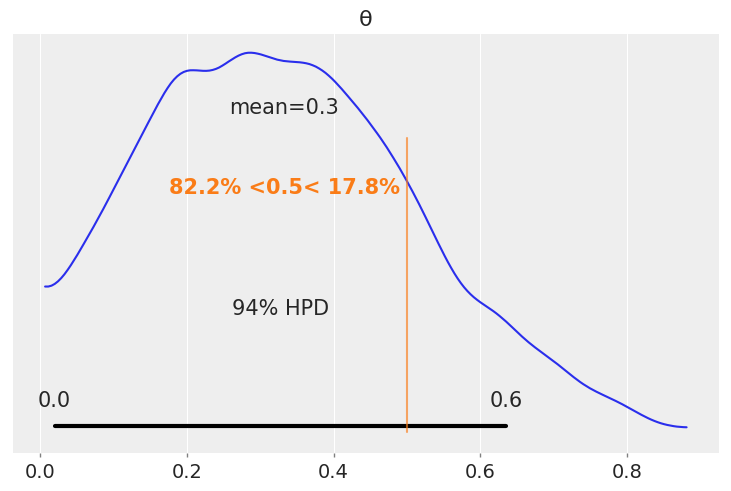

In [9]:
az.plot_posterior(trace, ref_val=0.5)
plt.savefig('B11197_02_04.png', dpi=300)

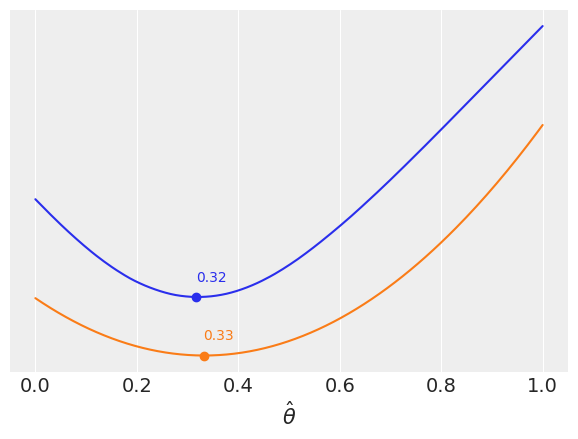

In [10]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_05.png', dpi=300)

In [11]:
np.mean(θ_pos), np.median(θ_pos)

(0.33279742978831917, 0.3191785396194514)

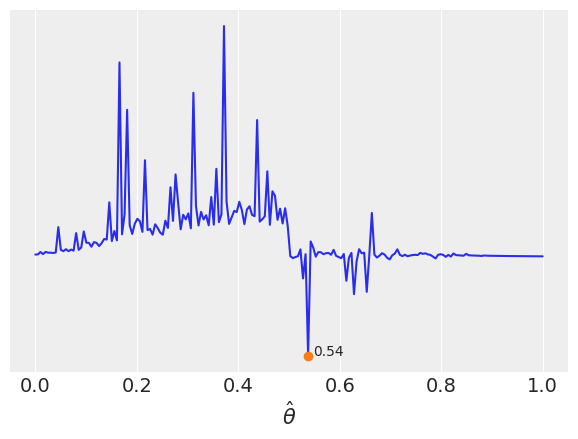

In [12]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_06.png', dpi=300)

## Gaussian inferences

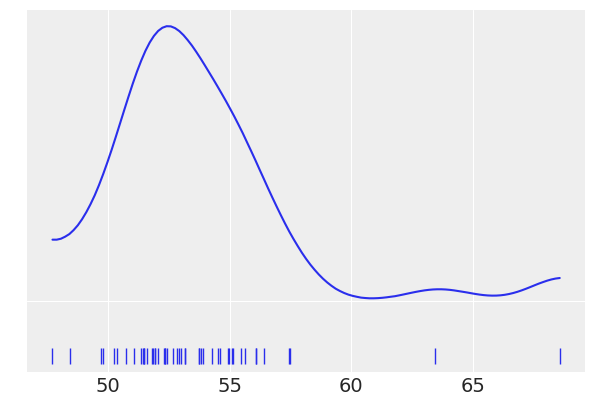

In [13]:
data = np.loadtxt('../data/chemical_shifts.csv')

# remove outliers using the interquartile rule
#quant = np.percentile(data, [25, 75])
#iqr = quant[1] - quant[0]
#upper_b = quant[1] + iqr * 1.5
#lower_b = quant[0] - iqr * 1.5
#data = data[(data > lower_b) & (data < upper_b)]
#print(np.mean(data), np.std(data))

az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)
plt.savefig('B11197_02_07.png', dpi=300)

 <img src="B11197_02_08.png" width="500">

In [14]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2588.38draws/s]


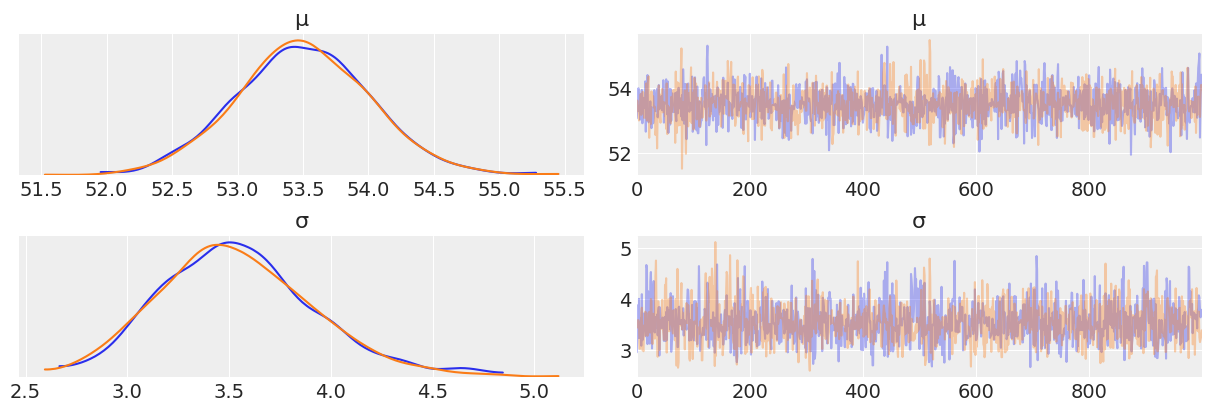

In [15]:
az.plot_trace(trace_g)
plt.savefig('B11197_02_09.png', dpi=300)

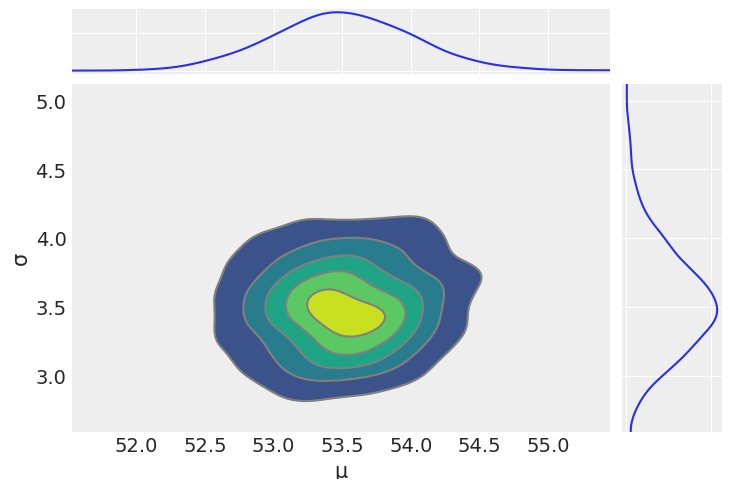

In [16]:
az.plot_joint(trace_g, kind='kde', fill_last=False)
plt.savefig('B11197_02_10.png', dpi=300)

In [17]:
az.summary(trace_g)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ,53.49,0.50,0.00,52.5,54.39,2081.0,1.0
σ,3.54,0.38,0.01,2.8,4.22,1823.0,1.0


In [18]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

100%|██████████| 100/100 [00:00<00:00, 1412.82it/s]


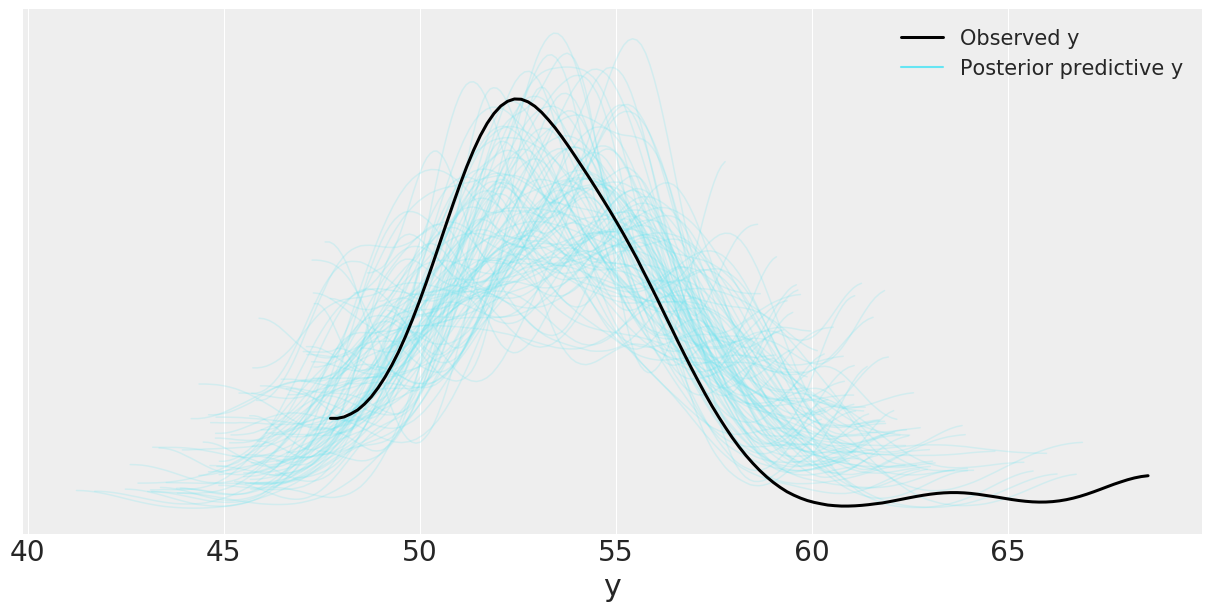

In [19]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.savefig('B11197_02_11.png', dpi=300)

### Robust inferences

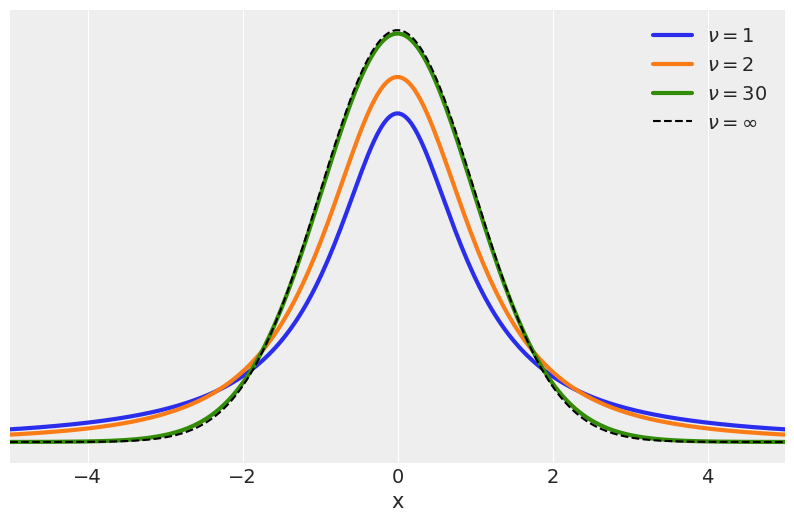

In [20]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('B11197_02_12.png', dpi=300)

 <img src="B11197_02_13.png" width="500">

In [21]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1501.27draws/s]


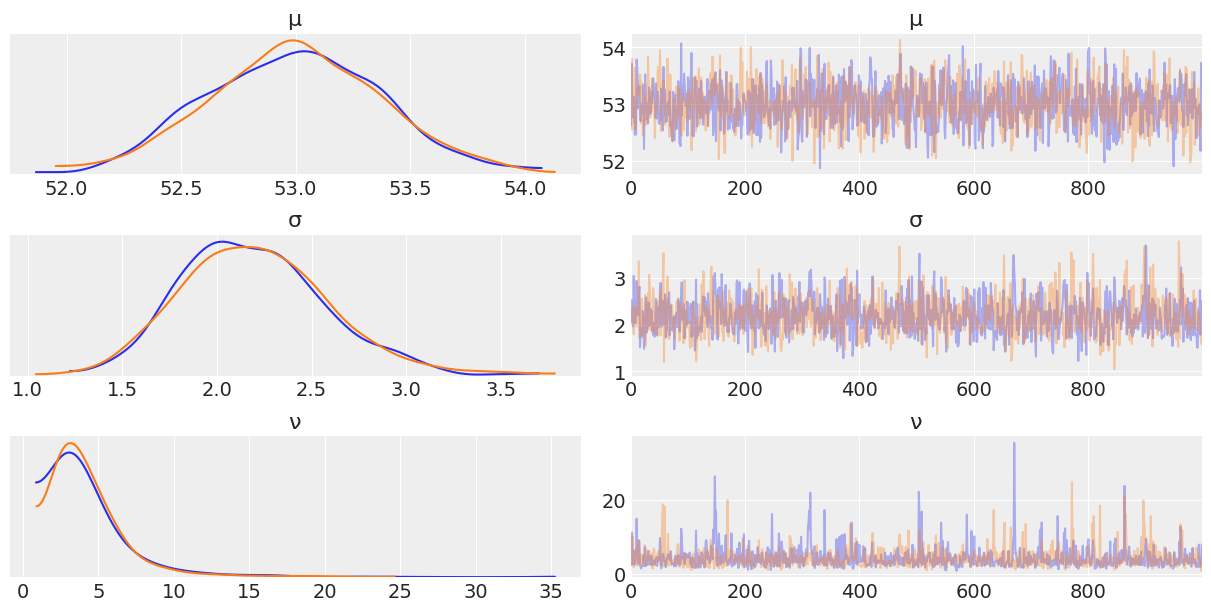

In [22]:
az.plot_trace(trace_t)
plt.savefig('B11197_02_14.png', dpi=300)

In [23]:
az.summary(trace_t)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ,52.99,0.38,0.01,52.33,53.74,1390.0,1.0
σ,2.19,0.39,0.01,1.53,2.95,1087.0,1.0
ν,4.36,2.79,0.10,1.36,9.11,927.0,1.0


100%|██████████| 100/100 [00:00<00:00, 1937.85it/s]


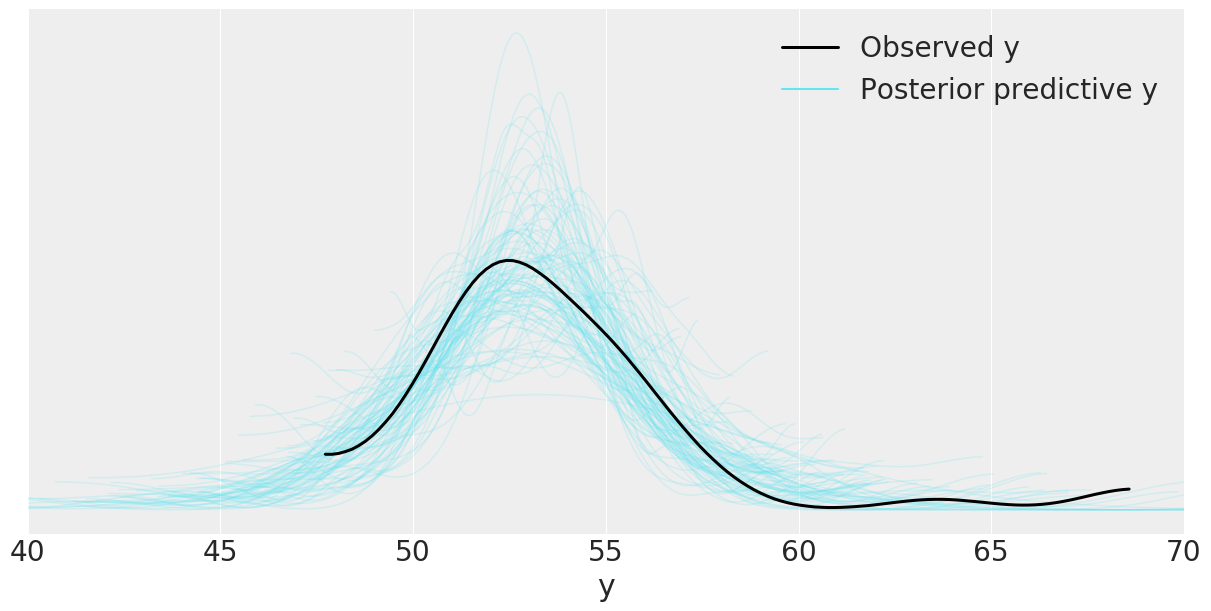

In [24]:
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)
plt.savefig('B11197_02_15.png', dpi=300)

# Tips example

In [25]:
tips = pd.read_csv('../data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


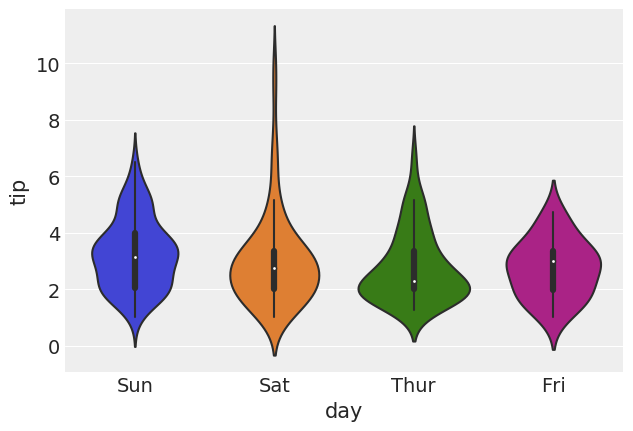

In [26]:
sns.violinplot(x='day', y='tip', data=tips)
plt.savefig('B11197_02_16.png', dpi=300)

In [27]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:12<00:00, 902.70draws/s] 


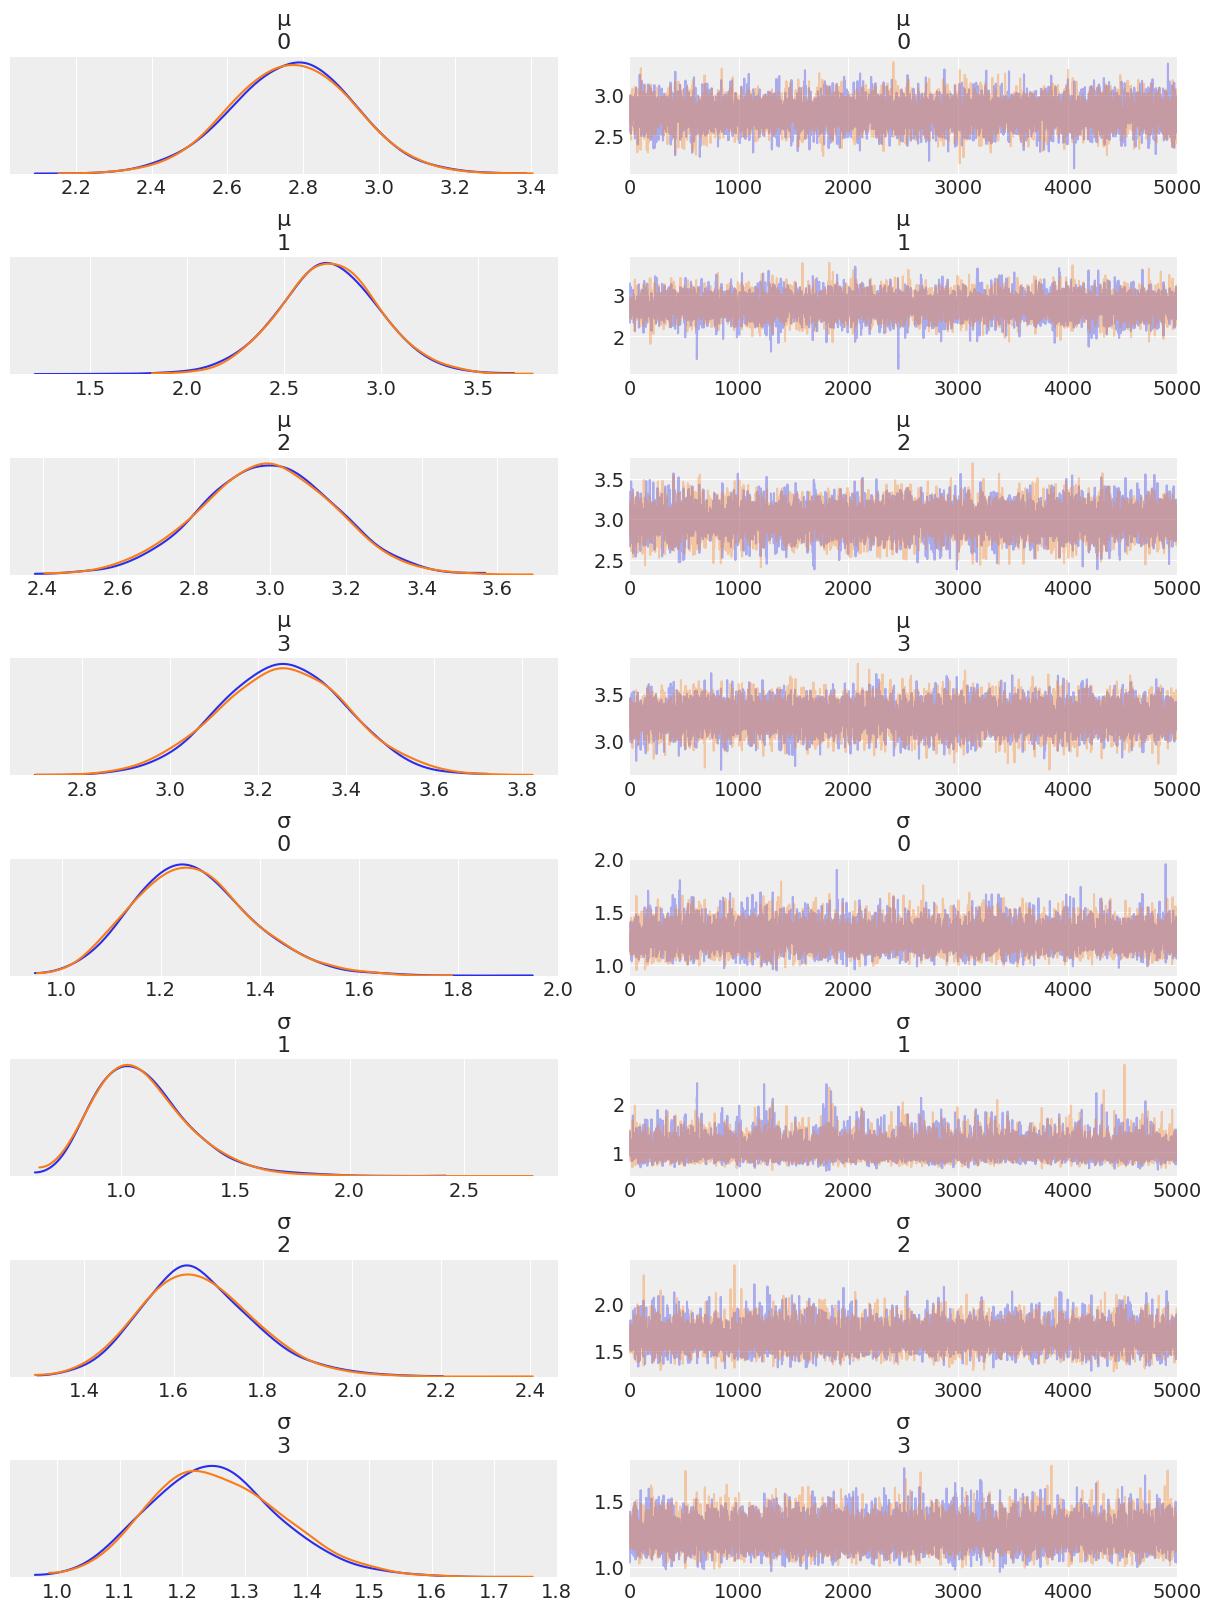

In [28]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)
plt.savefig('B11197_02_17.png', dpi=300)

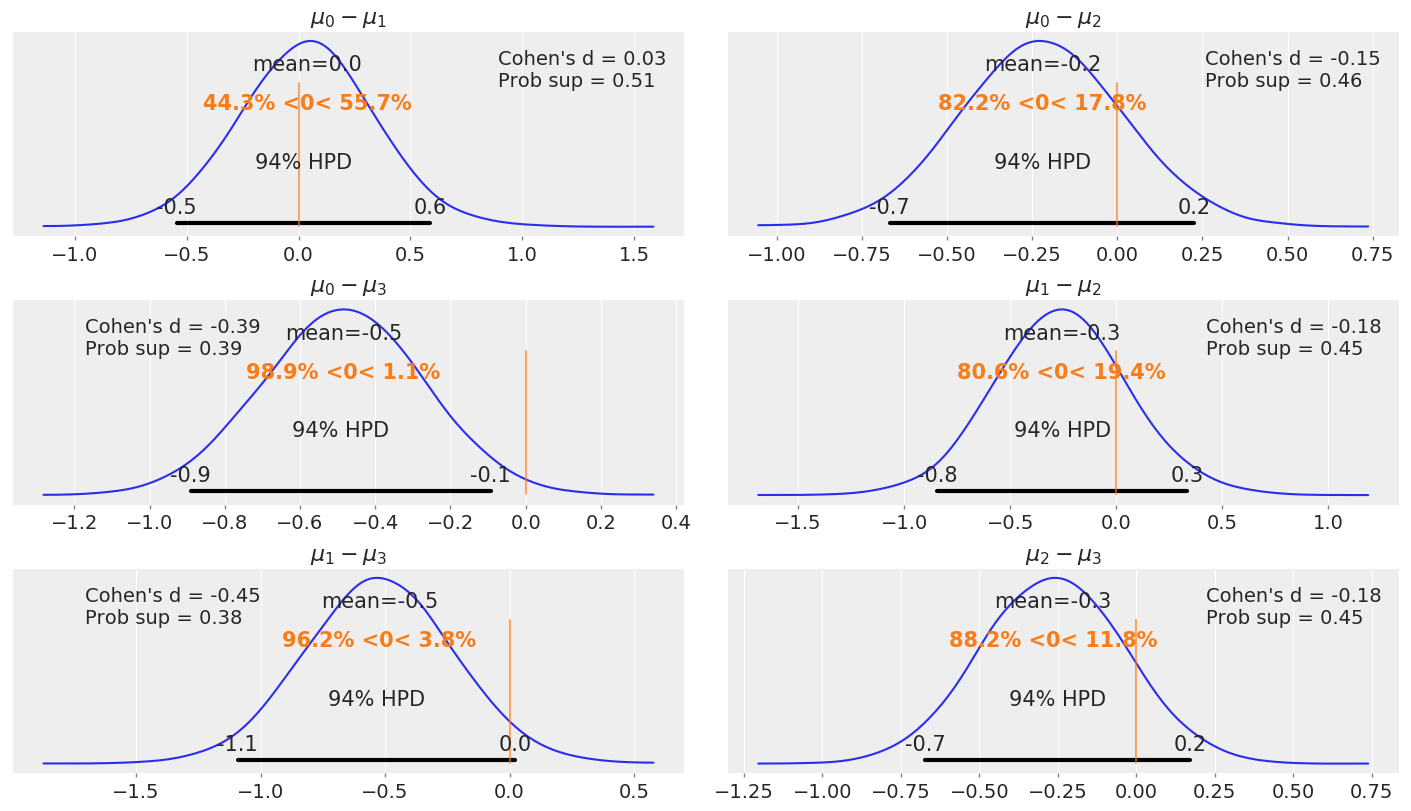

In [29]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()
plt.savefig('B11197_02_18.png', dpi=300)

# Hierarchical Models

 <img src="B11197_02_19.png" width="500">

In [30]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [31]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, κ, μ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1177.41draws/s]


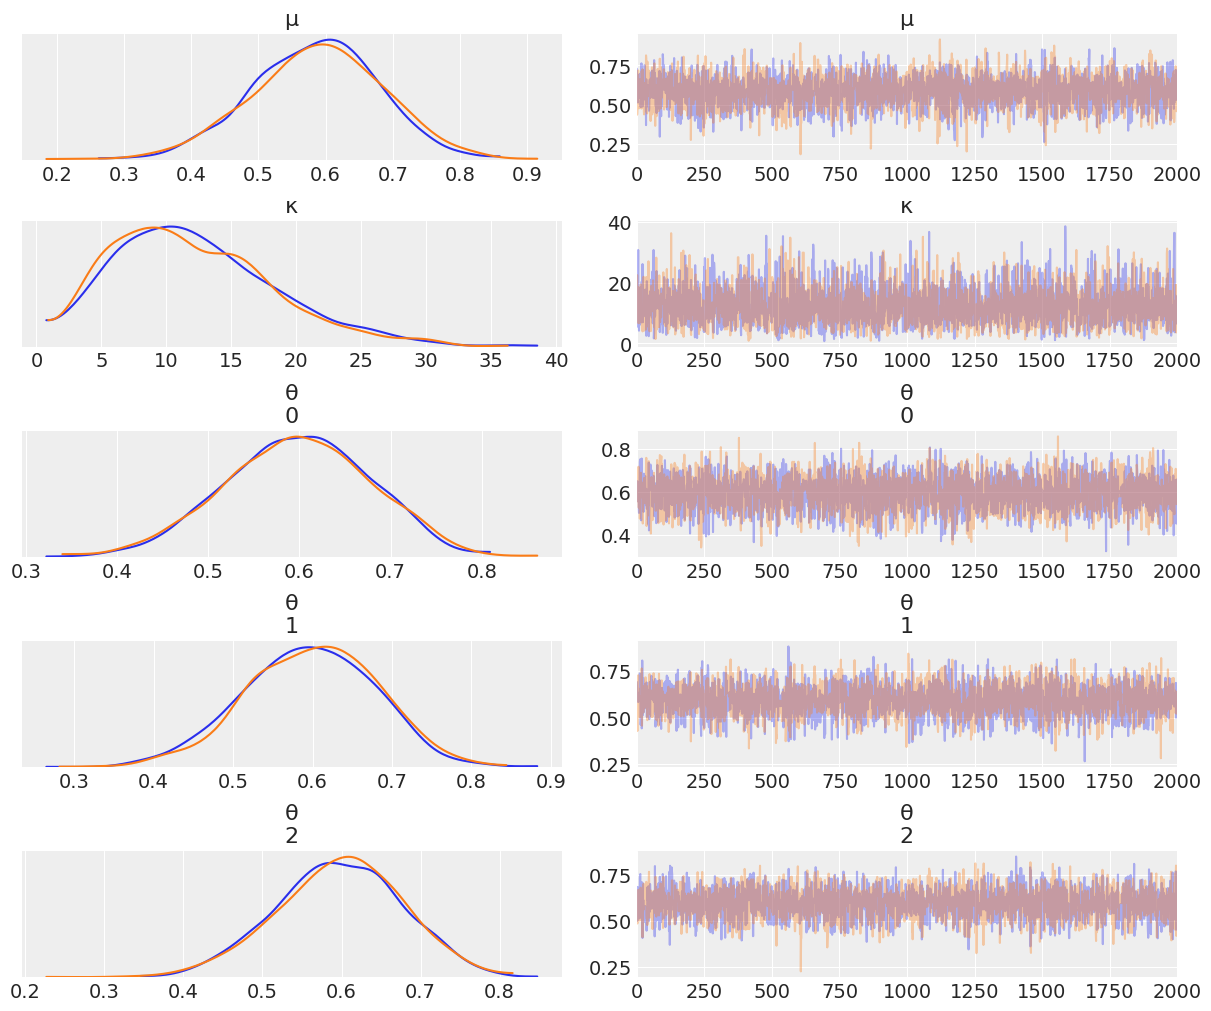

In [32]:
az.plot_trace(trace_h)
plt.savefig('B11197_02_20.png', dpi=300)

In [33]:
az.summary(trace_h)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ,0.58,0.10,0.00,0.40,0.76,3111.0,1.0
κ,12.18,6.18,0.14,2.13,24.00,2814.0,1.0
θ[0],0.60,0.08,0.00,0.45,0.74,3651.0,1.0
θ[1],0.60,0.08,0.00,0.45,0.74,3008.0,1.0
θ[2],0.60,0.08,0.00,0.45,0.74,3271.0,1.0


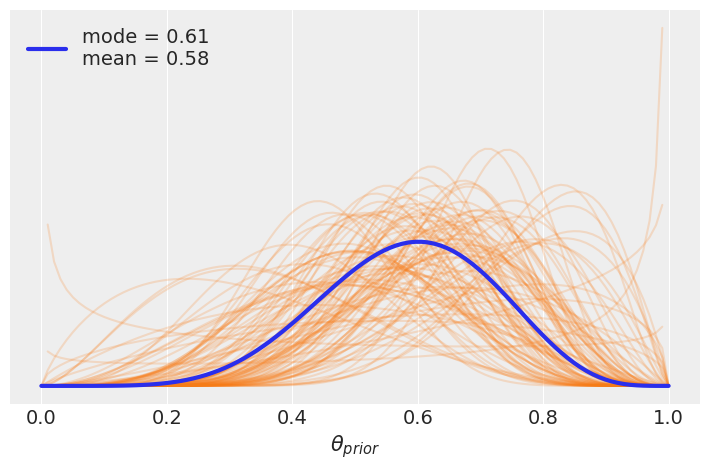

In [34]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()
plt.savefig('B11197_02_21.png', dpi=300)

In [35]:
cs_data = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

In [36]:
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_nh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 646.15draws/s]


In [37]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ, σ_μ, μ_μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 619.31draws/s] 


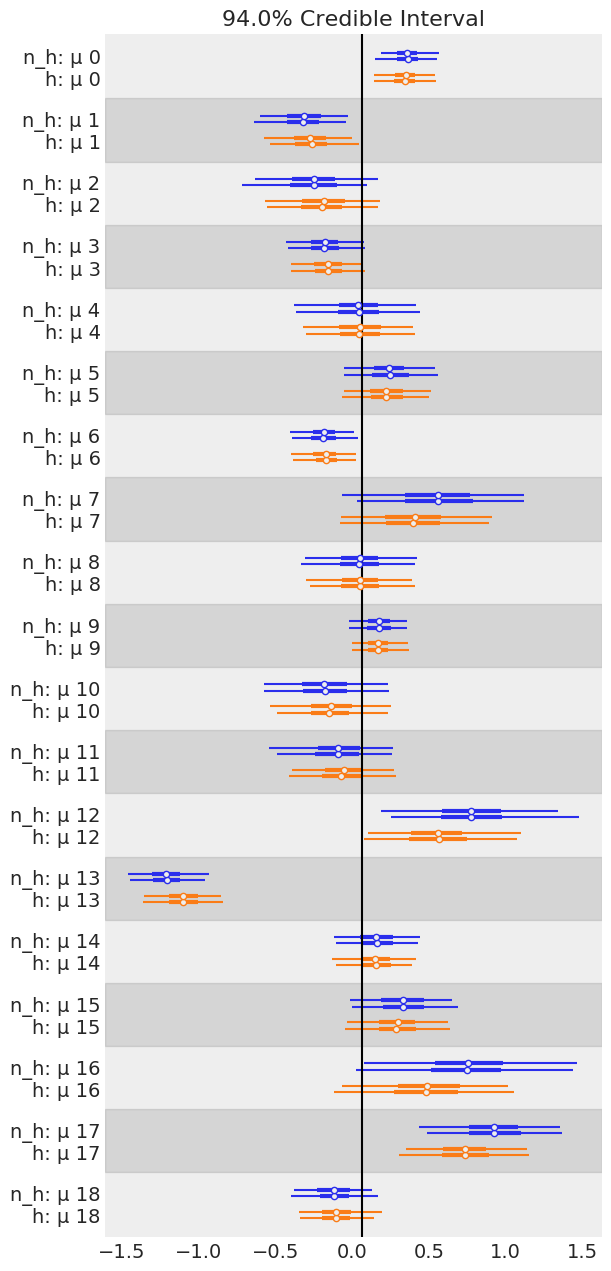

In [38]:
_, axes = az.plot_forest([trace_cs_nh, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)
plt.savefig('B11197_02_22.png', dpi=300)